In [1]:
##!python
#!/usr/bin/env python

import os
import shutil
from scipy.io import loadmat
import numpy as np
import scipy.io
from operator import itemgetter
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2 
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras
from keras.optimizers import RMSprop
from tensorflow.keras.layers import (
                                    Dense,
                                    Conv2D, 
                                    BatchNormalization, 
                                    ReLU, 
                                    Add,
                                    Input,
                                    MaxPooling2D,
                                    UpSampling2D,
                                    )
from keras.models import Model
from keras.losses import mean_squared_error
from math import exp
from sklearn.model_selection import train_test_split
%matplotlib inline

# Limpieza de Datos

## funciones:

In [2]:
############################################################################
def generate_dataset_obj(obj):
    if type(obj) == np.ndarray:
        dim = obj.shape[0]
        if dim == 1:
            ret = generate_dataset_obj(obj[0])             
        else:
            ret = []
            for i in range(dim):
                ret.append(generate_dataset_obj(obj[i]))                

    elif type(obj) == scipy.io.matlab.mio5_params.mat_struct:
        ret = {}
        for field_name in obj._fieldnames:            
            field = generate_dataset_obj(obj.__dict__[field_name])
            if field_name in must_be_list_fields:
                field = [field]
                ret[field_name] = field

    else:
        ret = obj

    return ret
############################################################################
def generate_dataset_obj(obj):
    if type(obj) == np.ndarray:
        dim = obj.shape[0]
        if dim == 1:
            ret = generate_dataset_obj(obj[0])             
        else:
            ret = []
            for i in range(dim):
                ret.append(generate_dataset_obj(obj[i]))                

    elif type(obj) == scipy.io.matlab.mio5_params.mat_struct:
        ret = {}
        for field_name in obj._fieldnames:            
            field = generate_dataset_obj(obj.__dict__[field_name])
            if field_name in must_be_list_fields:
                field = [field]
                ret[field_name] = field

    else:
        ret = obj

    return ret

############################################################################
def print_dataset_obj(obj, depth = 0, maxIterInArray = 20):
    prefix = "  "*depth
    if type(obj) == dict:
        for key in obj.keys():
            print("{}{}".format(prefix, key))
            print_dataset_obj(obj[key], depth + 1)
    elif type(obj) == list:
        for i, value in enumerate(obj):
            if i >= maxIterInArray:
                break
            print("{}{}".format(prefix, i))
            print_dataset_obj(value, depth + 1)
    else:
        print("{}{}".format(prefix, obj))
############################################################################
def return_image_joints(name,data):
    for item in data: # guardar coordenadas de los joints
        if item[0] == name:
            #print(item[1]) 
            return item[1]
############################################################################
rightconnections = [
                    (0,1),(1,2),(3,4),(4,5),(2,6),
                    (3,6),(6,7),(7,8),(8,9),(10,11),
                    (11,12),(12,7),(13,7),(13,14),(14,15)
                   ]
size_img_x = 256
size_img_y = 256
def draw_img_joints(file_name, data, resize = False ):    
    # Load image
    #img = cv2.imread(Path_To_Single_Person_Images + "/" + file_name,1)  
    img = image.load_img(Path_To_Single_Person_Images + "/" + file_name)
    img = image.img_to_array(img) 
    img = img/255
    if resize:
        img = np.float32(tf.image.resize(img,(size_img_x, size_img_y)))  
    pts = return_image_joints(file_name, data)        
    #plt.imshow(img)  
    X = [x[0] for x in pts]
    Y = [y[1] for y in pts]
    X = [int(x) for x in X]
    Y = [int(y) for y in Y]
    
    for i in range(16):
        for j in range(16):
            if (i,j) in rightconnections:
                if X[i]>0 and X[j]>0 and Y[i]>0 and Y[j]>0:
                    img = cv2.line(img,(X[i],Y[i]),(X[j],Y[j]),(1,0,0),5)
                    plt.scatter(X[i], Y[i], marker="o", color="red", s=20)
                    plt.scatter(X[j], Y[j], marker="o", color="red", s=20)
                    
    plt.imshow(img)
############################################################################
def load_image(train_data, a, b):
    train = np.asarray(train_data[a:b])
    train_image = np.zeros((b-a,size_img_x,size_img_y,3))
    for i in tqdm(range(a,b)):
        name_img = train[i][0]
        img = image.load_img(Path_To_Single_Person_Images + '/' + name_img)
        img = image.img_to_array(img)
        img_x = img.shape[1]
        img_y = img.shape[0]
        scala_x = img_x / size_img_x
        scala_y = img_y / size_img_y
        for j in range(len(train[i][1])): # escala los puntos clave
            train[i][1][j] = np.array([train[i][1][j][0] / scala_x, train[i][1][j][1] / scala_y])            
        img = tf.image.resize(img,(size_img_x, size_img_y))        
        img = img/255
        train_image[i] = img
    return train_image, train
############################################################################
def MakeHeatmap(x, y, width, height, show = False):
    # Probability as a function of distance from the center derived
    # from a gaussian distribution with mean = 0 and stdv = 1
    scaledGaussian = lambda x : exp(-(1/2)*(x**2))

    imgSize = (height, width)
    center_x = x
    center_y = y

    isotropicGrayscaleImage = np.zeros((imgSize[0],imgSize[1]),np.uint8)

    for i in range(imgSize[0]):
        for j in range(imgSize[1]):

            # find euclidian distance from center of image (x,y) 
            # and scale it to range of 0 to 2.5 as scaled Gaussian
            # returns highest probability for x=0 and approximately
            # zero probability for x > 2.5

            distanceFromCenter = np.linalg.norm(np.array([i-center_y,j-center_x]))
            #distanceFromCenter = 18*distanceFromCenter/(imgSize/2)
            scaledGaussianProb = scaledGaussian(distanceFromCenter)
            isotropicGrayscaleImage[i,j] = np.clip(scaledGaussianProb*255,0,255)   
    
    return isotropicGrayscaleImage
############################################################################    
def Joints_heatmaps(lista_de_joints, heatmap_size_x, heatmap_size_y, num_heatmaps = 16, show = False):
    heatmaps = np.zeros((16,64,64))
    for i in range(num_heatmaps):
        x, y = lista_de_joints[i] 
        x = x / 4 # entre 4 por que el array es de 256x256
        y = y / 4 # entre 4 por que el array es de 256x256
        heatmaps[i] = MakeHeatmap(x, y, heatmap_size_x, heatmap_size_y)
    if show:
        plotImages(heatmaps, num_heatmaps)
    return heatmaps
############################################################################        
def plotImages(images_arr, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
if os.path.isfile('lista_de_imagenes.npy') and os.path.isfile('lista_de_joints.npy'):
    #Ahora cargamos las imagenes
    lista_de_joints = np.load('lista_de_joints.npy',allow_pickle=True)
    lista_de_imagenes = np.load('lista_de_imagenes.npy')    
else: 
    #darle formato de diccionario
    matph = './mpii.mat'
    decoded1 = loadmat(matph, struct_as_record=False)["RELEASE"]
    must_be_list_fields = ["annolist","image","name", "annorect", "scale", "x", "y", "annopoints", "point", "id"]
    # Convert to dict
    dataset_obj = generate_dataset_obj(decoded1)
    # Print it out
    #print_dataset_obj(dataset_obj)
    len(dataset_obj['annolist'][0])
    #solo queremos la información en 'annolist'
    dataset = dataset_obj['annolist'][0]
    #guardamos solo informacion de las imagenes que tienen solo una persona
    train_data = []
    for i in range(len(dataset)):
        if "annopoints" in dataset[i]['annorect'][0]:     
            name = dataset[i]['image'][0]['name'][0]
            tupla = [] 
            for j in range(16):     #ordena los puntos de articulaciones del id = 0 al id = 15       
                try:
                    x = dataset[i]['annorect'][0]['annopoints'][0]['point'][0][j]['x'][0]
                except:
                    x = -1
                try:
                    y = dataset[i]['annorect'][0]['annopoints'][0]['point'][0][j]['y'][0]
                except:
                    y = -1
                try:
                    id = dataset[i]['annorect'][0]['annopoints'][0]['point'][0][j]['id'][0]
                except:
                    id = -1          
                tupla.append((x,y,id))
            tupla = sorted(tupla, key = itemgetter(2)) # esto lo ordena
            for j in range(len(tupla)):   #quita id de las tuplas,
                tupla[j] = tupla[j][:2]
            #pasa de tupla a array
            tupla = np.asarray(tupla)        
            train_data.append((name,tupla))
    #Creamos un array para guardar los nombres        
    names = []
    for item in train_data:#guardar nombres de las imagenes que voy a usar en "name"
        names.append(item[0])

    #Crear Carpeta para guardar imagenes del dataset
    Path_To_Raw_Images = 'DataSet/mpii_human_pose_v1_images'
    Path_To_Single_Person_Images = 'DataSet/mpii_human_pose_v1_images/SinglePersonImagesWithData'
    os.chdir(Path_To_Raw_Images)

    if os.path.isdir('SinglePersonImagesWithData') is False:
        os.makedirs('SinglePersonImagesWithData')
        for images in names:
            shutil.move(images, 'SinglePersonImagesWithData')

    os.chdir('../../')

    #Demostración dibujar joints en imagenes con data
    #draw_img_joints('060111501.jpg',train_data)
    
    #Ahora cargamos las imagenes
    lista_de_imagenes, lista_de_joints = load_image(train_data,0,5000)
    np.save('lista_de_imagenes', lista_de_imagenes)
    np.save('lista_de_joints', lista_de_joints)

#lista_de_joints.shape
#draw_img_joints(lista_de_joints[17][0],lista_de_joints, resize = True)

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [9]:
lista_de_imagenes.shape

(5000, 256, 256, 3)

In [ ]:
#darle formato de diccionario
matph = './mpii.mat'
decoded1 = loadmat(matph, struct_as_record=False)["RELEASE"]
must_be_list_fields = ["annolist","image","name", "annorect", "scale", "x", "y", "annopoints", "point", "id"]

In [3]:
def generate_dataset_obj(obj):
    if type(obj) == np.ndarray:
        dim = obj.shape[0]
        if dim == 1:
            ret = generate_dataset_obj(obj[0])             
        else:
            ret = []
            for i in range(dim):
                ret.append(generate_dataset_obj(obj[i]))                

    elif type(obj) == scipy.io.matlab.mio5_params.mat_struct:
        ret = {}
        for field_name in obj._fieldnames:            
            field = generate_dataset_obj(obj.__dict__[field_name])
            if field_name in must_be_list_fields:
                field = [field]
                ret[field_name] = field

    else:
        ret = obj

    return ret

In [4]:
def print_dataset_obj(obj, depth = 0, maxIterInArray = 20):
    prefix = "  "*depth
    if type(obj) == dict:
        for key in obj.keys():
            print("{}{}".format(prefix, key))
            print_dataset_obj(obj[key], depth + 1)
    elif type(obj) == list:
        for i, value in enumerate(obj):
            if i >= maxIterInArray:
                break
            print("{}{}".format(prefix, i))
            print_dataset_obj(value, depth + 1)
    else:
        print("{}{}".format(prefix, obj))

# Convert to dict
dataset_obj = generate_dataset_obj(decoded1)

In [5]:
# Print it out
#print_dataset_obj(dataset_obj)

In [6]:
len(dataset_obj['annolist'][0])
dataset = dataset_obj['annolist'][0]

In [7]:
#guarda solo informacion de las imagenes que tienen solo una persona
train_data = []
for i in range(len(dataset)):
    if "annopoints" in dataset[i]['annorect'][0]:     
        name = dataset[i]['image'][0]['name'][0]
        tupla = [] 
        for j in range(16):     #ordena los puntos de articulaciones del id = 0 al id = 15       
            try:
                x = dataset[i]['annorect'][0]['annopoints'][0]['point'][0][j]['x'][0]
            except:
                x = -1
            try:
                y = dataset[i]['annorect'][0]['annopoints'][0]['point'][0][j]['y'][0]
            except:
                y = -1
            try:
                id = dataset[i]['annorect'][0]['annopoints'][0]['point'][0][j]['id'][0]
            except:
                id = -1          
            tupla.append((x,y,id))
        tupla = sorted(tupla, key = itemgetter(2)) # esto lo ordena
        for j in range(len(tupla)):   #quita id de las tuplas,
            tupla[j] = tupla[j][:2]
        #pasa de tupla a array
        tupla = np.asarray(tupla)        
        train_data.append((name,tupla))

In [8]:
#len(train_data)
names = []
for item in train_data:#guardar nombres de las imagenes que voy a usar en "name"
    names.append(item[0])

In [9]:
#train_data
#names
def return_image_joints(name,data):
    for item in data: # guardar coordenadas de los joints
        if item[0] == name:
            #print(item[1]) 
            return item[1]

In [10]:
train_data[0][1]

array([[980.    , 322.    ],
       [896.    , 318.    ],
       [865.    , 248.    ],
       [943.    , 226.    ],
       [948.    , 290.    ],
       [881.    , 349.    ],
       [904.    , 237.    ],
       [858.    , 135.    ],
       [871.1877, 180.4244],
       [835.8123,  58.5756],
       [772.    , 294.    ],
       [754.    , 247.    ],
       [792.    , 147.    ],
       [923.    , 123.    ],
       [995.    , 163.    ],
       [961.    , 223.    ]])

In [11]:
#Crear Carpeta para guardar imagenes del dataset
Path_To_Raw_Images = 'DataSet/mpii_human_pose_v1_images'
Path_To_Single_Person_Images = 'DataSet/mpii_human_pose_v1_images/SinglePersonImagesWithData'
os.chdir(Path_To_Raw_Images)

if os.path.isdir('SinglePersonImagesWithData') is False:
    os.makedirs('SinglePersonImagesWithData')
    for images in names:
        shutil.move(images, 'SinglePersonImagesWithData')
        
os.chdir('../../')

In [12]:
rightconnections = [(0,1),(1,2),(3,4),(4,5),(2,6),(3,6),(6,7),(7,8),(8,9),(10,11),(11,12),(12,7),(13,7),(13,14),(14,15)]
size_img_x = 256
size_img_y = 256
def draw_img_joints(file_name, data, resize = False ):    
    # Load image
    #img = cv2.imread(Path_To_Single_Person_Images + "/" + file_name,1)  
    img = image.load_img(Path_To_Single_Person_Images + "/" + file_name)
    img = image.img_to_array(img) 
    img = img/255
    if resize:
        img = np.float32(tf.image.resize(img,(size_img_x, size_img_y)))  
    pts = return_image_joints(file_name, data)        
    #plt.imshow(img)  
    X = [x[0] for x in pts]
    Y = [y[1] for y in pts]
    X = [int(x) for x in X]
    Y = [int(y) for y in Y]
    
    for i in range(16):
        for j in range(16):
            if (i,j) in rightconnections:
                if X[i]>0 and X[j]>0 and Y[i]>0 and Y[j]>0:
                    img = cv2.line(img,(X[i],Y[i]),(X[j],Y[j]),(1,0,0),5)
                    plt.scatter(X[i], Y[i], marker="o", color="red", s=20)
                    plt.scatter(X[j], Y[j], marker="o", color="red", s=20)
                    
    plt.imshow(img)

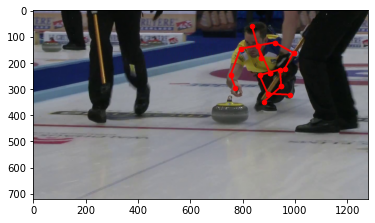

In [13]:
#Demostración dibujar joints en imagenes con data
#img = image.load_img(Path_To_Single_Person_Images + "/" + '060111501.jpg')
#img = image.img_to_array(img) 
#img = img/255
draw_img_joints('060111501.jpg',train_data)

In [14]:
#Ahora cargamos las imagenes
def load_image(train_data, a, b):
    train = np.asarray(train_data[a:b])
    train_image = np.zeros((b-a,size_img_x,size_img_y,3))
    for i in tqdm(range(a,b)):
        name_img = train[i][0]
        img = image.load_img(Path_To_Single_Person_Images + '/' + name_img)
        img = image.img_to_array(img)
        img_x = img.shape[1]
        img_y = img.shape[0]
        scala_x = img_x / size_img_x
        scala_y = img_y / size_img_y
        for j in range(len(train[i][1])): # escala los puntos clave
            train[i][1][j] = np.array([train[i][1][j][0] / scala_x, train[i][1][j][1] / scala_y])            
        img = tf.image.resize(img,(size_img_x, size_img_y))        
        img = img/255
        train_image[i] = img
    return train_image, train

In [15]:
#lista_de_imagenes, lista_de_joints = load_image(train_data,0,5000)

if os.path.isfile('lista_de_imagenes.npy') and os.path.isfile('lista_de_joints.npy'):
    lista_de_imagenes = np.load('lista_de_imagenes.npy')
    lista_de_joints = np.load('lista_de_joints.npy')
else:    
    lista_de_imagenes, lista_de_joints = load_image(train_data,0,5000)
    np.save('lista_de_imagenes', lista_de_imagenes)
    np.save('lista_de_joints', lista_de_joints)
""" """

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:25<00:00, 18.83it/s]


' '

In [16]:
lista_de_joints.shape

(5000, 2)

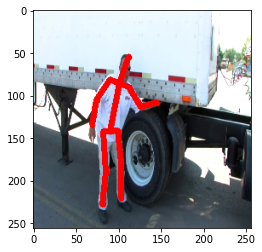

In [46]:
draw_img_joints(lista_de_joints[17][0],lista_de_joints, resize = True)

In [18]:
y_data = []
for item in lista_de_joints:
    joints = return_image_joints(item[0], lista_de_joints)
    joints_clear = []
    for tuplas in joints:
        joints_clear.append(tuplas[0]) #joint x
        joints_clear.append(tuplas[1]) #joint y
    y_data.append(joints_clear)

# Heatmap preprocessor

In [38]:
heatmap_size_x = 64
heatmap_size_y = 64
def MakeHeatmap(x, y, width, height, show = False):
    # Probability as a function of distance from the center derived
    # from a gaussian distribution with mean = 0 and stdv = 1
    scaledGaussian = lambda x : exp(-(1/2)*(x**2))

    imgSize = (height, width)
    center_x = x
    center_y = y

    isotropicGrayscaleImage = np.zeros((imgSize[0],imgSize[1]),np.uint8)

    for i in range(imgSize[0]):
        for j in range(imgSize[1]):

            # find euclidian distance from center of image (x,y) 
            # and scale it to range of 0 to 2.5 as scaled Gaussian
            # returns highest probability for x=0 and approximately
            # zero probability for x > 2.5

            distanceFromCenter = np.linalg.norm(np.array([i-center_y,j-center_x]))
            #distanceFromCenter = 18*distanceFromCenter/(imgSize/2)
            scaledGaussianProb = scaledGaussian(distanceFromCenter)
            isotropicGrayscaleImage[i,j] = np.clip(scaledGaussianProb*255,0,255)   
    
    return isotropicGrayscaleImage
    

In [41]:
def Joints_heatmaps(lista_de_joints, num_heatmaps = 16, show = False):
    heatmaps = np.zeros((16,64,64))
    for i in range(num_heatmaps):
        x, y = lista_de_joints[i] 
        x = x / 4 # entre 4 por que el array es de 256x256
        y = y / 4 # entre 4 por que el array es de 256x256
        heatmaps[i] = MakeHeatmap(x, y, heatmap_size_x, heatmap_size_y)
    if show:
        plotImages(heatmaps, num_heatmaps)
    return heatmaps
        
def plotImages(images_arr, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
  

In [40]:
dibujo_test_heatmaps = Joints_heatmaps(lista_de_joints[0][1], show = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.13it/s]


In [42]:
lista_de_heatmaps = np.zeros((5000,16,64,64))
for i in tqdm(range(lista_de_joints.shape[0])):
    joints = return_image_joints(lista_de_joints[i][0], lista_de_joints)
    lista_de_heatmaps[i] = Joints_heatmaps(joints)  

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [3:25:56<00:00,  2.47s/it]


In [47]:
np.save('lista_de_heatmaps', lista_de_heatmaps)

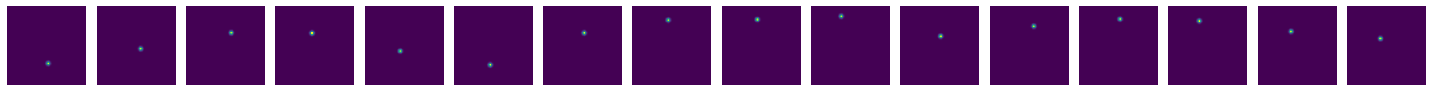

In [48]:
plotImages(lista_de_heatmaps[67], 16)

# RED NEURONAL

In [49]:
def conv2D(inputs, 
           filters, 
           kernel_size = 1,
           strides = 1,
           padding = 'same',
           kernel_initializer = 'he_normal',
           activation = True,
           batch_normalization = True,
           name = "conv"):
    
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding,
            use_bias=False, kernel_initializer=kernel_initializer)(inputs)
    if batch_normalization:
        x = BatchNormalization()(x)
    if activation:
        x = ReLU()(x)
    return x
    

In [50]:
#Arquitectura ResNetV2 de cuello de botella
def ResNetV2(inputs, filters, strides = 1, lift_channels = False, name = 'bloque'):
    
    res = inputs
    #incrementa el número de canales si es necesario
    if lift_channels:
        res = conv2D(
            inputs,
            filters,
            activation = False,
            batch_normalization = False)
    
    x = BatchNormalization()(inputs)
    x = ReLU()(x)
    
    #conv de tamaño 1x1
    x = conv2D(
        x,
        filters = filters/2)
    
    #conv de tamaño 3x3
    x = conv2D(
        x,
        filters = filters/2,
        kernel_size = 3)
    
    #conv de tamaño 1x1
    x = conv2D(
        x,
        filters = filters,
        activation = False,
        batch_normalization = False)
    
    x = Add()([res,x])
    
    return x

In [51]:
def HourglassUnit(inputs, depth, filters, resnet_per_block, name = 'hourglass_'):    
    
    #Capas "superiores"
    up_1 = ResNetV2(inputs,filters)
    
    for i in range(resnet_per_block):
        up_1 = ResNetV2(up_1, filters)
    
    #Capas "inferiores"
    #Reducir resolución
    low_1 = MaxPooling2D(pool_size = 2, strides = 2)(inputs)
    
    for i in range(resnet_per_block):
        low_1 = ResNetV2(low_1, filters)
    
    low_2 = low_1
    if depth > 1 : 
        low_2 = HourglassUnit(low_1, depth-1, filters, resnet_per_block)
    else:
        low_2 = ResNetV2(low_2, filters)
    
    low_3 = low_2
    
    for i in range(resnet_per_block):
        low_3 = ResNetV2(low_3, filters)
    
    #Aumentar resolución
    up_2 = UpSampling2D()(low_3)
    
    return Add()([up_1,up_2])
    

In [52]:
def HourglassNetwork(input_shape = (256,256,3), stacks = 8, resnet_per_block = 3, heatmaps = 16):
    
    inputs = Input(shape = input_shape)
    
    #la data llega en formato 256x256x3, la pasamos a 64x64x256
    #preprocessing
    #amplia canales a 64
    x = conv2D(
        inputs,
        filters = 64,
        kernel_size = 7,
        strides = 2)
    #amplia canales de 64 a 128 
    x = ResNetV2(x, filters = 128, lift_channels = True)
    x = MaxPooling2D(pool_size = 2, strides = 2)(x)
    x = ResNetV2(x, filters = 128)
    #amplia canales de 64 a 128
    x = ResNetV2(x, filters = 256, lift_channels = True)
    skip = x
    y_heatmaps = []
    
    for i in range(stacks):
        x = HourglassUnit(x, 4, filters = 256, resnet_per_block = resnet_per_block)
        
        x = ResNetV2(x, filters = 256)
        
        #prediccion de 256 canales 
        x = conv2D(x, filters = 256)
        
        #prediccion temporal de heatmaps
        y = conv2D(x, filters = heatmaps)
        #agregamos el resultado temportal al array de resultados para la supervision intermedia
        y_heatmaps.append(y)
        
        #ahora regresamos el tensor y al orden de 256 canales si es que no es el ultimo output
        if i < stacks - 1:
            y_recovery1 = conv2D(x, filters = 256, activation = False, batch_normalization = False)
            y_recovery2 = conv2D(y, filters = 256, activation = False, batch_normalization = False)
            x = Add()([skip, y_recovery1, y_recovery2])
    
    return Model(inputs = inputs, outputs = y_heatmaps, name = 'HourglassNetwork')

In [53]:
model = HourglassNetwork(stacks = 4)

In [54]:
rms = RMSprop(lr=5e-4)
model.compile(optimizer=rms, loss=mean_squared_error, metrics=["accuracy"])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(lista_de_imagenes, lista_de_heatmaps, random_state=7, test_size=0.2)

In [56]:
"""X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)"""

'X_train = np.array(X_train)\nX_test = np.array(X_test)\ny_train = np.array(y_train)\ny_test = np.array(y_test)'

In [57]:
#plt.imshow(X_train[0])
X_train.shape

(4000, 256, 256, 3)

In [58]:
y_train.shape

(4000, 16, 64, 64)

In [59]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=16)

Epoch 1/20


ValueError: in user code:

    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\losses.py:1195 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:10399 squared_difference
        "SquaredDifference", x=x, y=y, name=name)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\func_graph.py:593 _create_op_internal
        compute_device)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py:3485 _create_op_internal
        op_def=op_def)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py:1975 __init__
        control_input_ops, op_def)
    c:\users\espin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 64 and 16 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](HourglassNetwork/re_lu_137/Relu, IteratorGetNext:1)' with input shapes: [16,64,64,16], [16,16,64,64].
